# Simple Inference 
- QLoRA 방식으로 CoT finetuning 한 모델 추론
- LoRA Merge
- inferece

In [57]:
import sys
import os
import torch
import pandas as pd
import numpy as np
from transformers import AutoProcessor, AutoModelForCausalLM
from qwen_vl_utils import process_vision_info
from tqdm import tqdm
import pickle
import base64


In [58]:
# Add path for model utilities
sys.path.append("EyesMolProject/Qwen2-VL-Finetune")
from src.utils import (
    load_pretrained_model,
    get_model_name_from_path,
    disable_torch_init,
)

In [ ]:
# # LoRA 모델 병합
lora_path = 'EyesMolProject/Qwen2-VL-Finetune/output/qwen_3B_Qlora_cot_sft/checkpoint-6000' # 체크포인트 경로 설정하기 
save_path = 'EyesMolProject/checkpoint_merge'  # 저장될 폴더
model_base = 'Qwen2.5-VL-3B-Instruct' # 베이스모델

# # f-string을 사용하여 변수를 명령어에 전달
!python /workspace/EyesMolProject/Qwen2-VL-Finetune/src/merge_lora_weights.py --model-path {lora_path} --model-base {model_base} --save-model-path {save_path}

In [60]:
IMAGE_PATH = "/workspace/molecule_images"  # 이미지 경로
BASE_MODEL_PATH = model_base
TUNE_MODEL_PATH = save_path  # 튜닝 모델 경로
DEVICE = "cuda"

In [61]:
disable_torch_init()

# 모델 로드
base_model_name = get_model_name_from_path(BASE_MODEL_PATH)
base_processor, base_model = load_pretrained_model(
    model_base=BASE_MODEL_PATH,
    model_path=TUNE_MODEL_PATH,
    device_map=DEVICE,
    model_name=base_model_name,
    load_4bit=False,
    load_8bit=False,
    device=DEVICE,
    use_flash_attn=True,
    use_fast=True,
)

Loading model from EyesMolProject/checkpoint_merge as a standard model. Adapter files were not found, so it can't be merged


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [62]:
base_model.eval()

Qwen2_5_VLForConditionalGeneration(
  (model): Qwen2_5_VLModel(
    (visual): Qwen2_5_VisionTransformerPretrainedModel(
      (patch_embed): Qwen2_5_VisionPatchEmbed(
        (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
      )
      (rotary_pos_emb): Qwen2_5_VisionRotaryEmbedding()
      (blocks): ModuleList(
        (0-31): 32 x Qwen2_5_VLVisionBlock(
          (norm1): Qwen2RMSNorm((1280,), eps=1e-06)
          (norm2): Qwen2RMSNorm((1280,), eps=1e-06)
          (attn): Qwen2_5_VLVisionAttention(
            (qkv): Linear(in_features=1280, out_features=3840, bias=True)
            (proj): Linear(in_features=1280, out_features=1280, bias=True)
          )
          (mlp): Qwen2_5_VLMLP(
            (gate_proj): Linear(in_features=1280, out_features=3420, bias=True)
            (up_proj): Linear(in_features=1280, out_features=3420, bias=True)
            (down_proj): Linear(in_features=3420, out_features=1280, bias=True)
            (act_fn): SiLU()

In [ ]:
df = pd.DataFrame(pd.read_json('uspto_cot_llava_test.json'))

In [ ]:
# /workspace/uspto_mol/2002/20020101/US06334452-20020101/US06334452-20020101-C00001.png

In [ ]:
import os
from PIL import Image
from tqdm import tqdm

from PIL import Image

# # 단일 파일 변환
# img = Image.open('image.tif')
# img.save('image.png', 'PNG')

# # 여러 파일 일괄 변환
import glob
from PIL import Image

# 모든 하위 디렉토리의 TIF 파일 찾기
for tif_file in glob.glob('**/*.TIF', recursive=True):
    img = Image.open(tif_file)
    png_file = tif_file.replace('.TIF', '.png')
    img.save(png_file, 'PNG')
    print(f"변환: {tif_file}")



In [ ]:
# 경로 업데이트  
df['image'] = df['image'].str.replace('.TIF', '.png')

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
df['image']

In [ ]:
import os

output_dir = "/workspace/molecule_images"
os.makedirs(output_dir, exist_ok=True)

for idx, row in df_filtered.iterrows():
    img_bytes = row['image']['bytes']
    path = row['image']['path']
    filename = os.path.join(output_dir, f"{path}")
    
    with open(filename, "wb") as f:
        f.write(img_bytes)

    print(f"Saved image {idx} to {filename}")


In [38]:
all_results = []
save_count = 0

In [ ]:
# 추론하다가 중간에 멈춰서 chunk 파일 있을 경우 여기서부터 다시 시도
# import glob

# chunk_list = glob.glob("/workspace/temp/*.pkl")
# chunk_df = pd.DataFrame()
# for i in chunk_list:
#     chunk_df = pd.concat([chunk_df, pd.DataFrame(pd.read_pickle(i))])
# df_sampled = pd.concat([df_sampled, chunk_df], ignore_index=True)
# df_sampled = df_sampled.drop_duplicates(subset=["image", "Q"], keep=False)

In [ ]:
# 배치 단위 추론
batch_size = 200
from PIL import Image
from io import BytesIO
messages = [
    [
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": f"file://{os.path.join(row['image'])}",
                },
                {
                    "type": "text",
                    "text": """
This is a schematic diagram of a chemical molecular structure.
You are required to list the types of atomic elements in the diagram, the coordinates of the atoms, and the chemical bonds between all the atoms.

In your predicted results, the type of bond is replaced by a number,
with a single bond being 1, a double bond being 2, a triple bond being 3,
an aromatic bond being 4, a solid wedge being 5, and a dashed wedge being 6.
displays the results in JSON list format strictly following the format below.

[
  {"a": "C", "id": 0, "xy": [x1, y1]},
  {"b": 1, "a1": 0, "a2": 1},
]

a means atom, xy means coordinates, b means bond, a1 and a2 means the atom id of the bond.

Then, based on atoms and bonds that you have listed, output a canonical SMILES in JSON format with the key 'smiles'.

Example format:
{
  "smiles": "C1=CC=CC=C1"
}

Again, strictly follow the given format and do not add any extra explanations or content.
"""
                },
            ],
        }
    ]
    for _, row in df.iterrows()
]



In [ ]:
# 단일 이미지에 대한 추론
new_messages = [
    [
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": f"file:///workspace/uspto_mol/2008/I20080429/US07364824-20080429/US07364824-20080429-C00016.png",
                },
                {
                    "type": "text",
                    "text": """
This is a schematic diagram of a chemical molecular structure.
You are required to list the types of atomic elements in the diagram, the coordinates of the atoms, and the chemical bonds between all the atoms.

In your predicted results, the type of bond is replaced by a number,
with a single bond being 1, a double bond being 2, a triple bond being 3,
an aromatic bond being 4, a solid wedge being 5, and a dashed wedge being 6.
displays the results in JSON list format strictly following the format below.

[
  {"a": "C", "id": 0, "xy": [x1, y1]},
  {"b": 1, "a1": 0, "a2": 1},
]

a means atom, xy means coordinates, b means bond, a1 and a2 means the atom id of the bond.

Then, based on atoms and bonds that you have listed, output a canonical SMILES in JSON format with the key 'smiles'.

Example format:
{
  "smiles": "C1=CC=CC=C1"
}

Again, strictly follow the given format and do not add any extra explanations or content.
"""
                },
            ],
        }
    ]
]


In [93]:
# 단일 메시지 배치를 직접 생성하여 테스트
new_batches = [[new_messages]]
new_batches


[[[[{'role': 'user',
     'content': [{'type': 'image',
       'image': 'file:///workspace/uspto_mol/2008/I20080429/US07364824-20080429/US07364824-20080429-C00016.png'},
      {'type': 'text',
       'text': '\nThis is a schematic diagram of a chemical molecular structure.\nYou are required to list the types of atomic elements in the diagram, the coordinates of the atoms, and the chemical bonds between all the atoms.\n\nIn your predicted results, the type of bond is replaced by a number,\nwith a single bond being 1, a double bond being 2, a triple bond being 3,\nan aromatic bond being 4, a solid wedge being 5, and a dashed wedge being 6.\ndisplays the results in JSON list format strictly following the format below.\n\n[\n  {"a": "C", "id": 0, "xy": [x1, y1]},\n  {"b": 1, "a1": 0, "a2": 1},\n]\n\na means atom, xy means coordinates, b means bond, a1 and a2 means the atom id of the bond.\n\nThen, based on atoms and bonds that you have listed, output a canonical SMILES in JSON format with 

In [ ]:
batch_size = 200 
batches = [messages[i : i + batch_size] for i in range(0, len(messages), batch_size)]

In [54]:
batches[0] # 확인용

[[{'role': 'user',
   'content': [{'type': 'image',
     'image': 'file://uspto_mol/2008/I20080429/US07364824-20080429/US07364824-20080429-C00016.png'},
    {'type': 'text',
     'text': '\nThis is a schematic diagram of a chemical molecular structure.\nYou are required to list the types of atomic elements in the diagram, the coordinates of the atoms, and the chemical bonds between all the atoms.\n\nIn your predicted results, the type of bond is replaced by a number,\nwith a single bond being 1, a double bond being 2, a triple bond being 3,\nan aromatic bond being 4, a solid wedge being 5, and a dashed wedge being 6.\ndisplays the results in JSON list format strictly following the format below.\n\n[\n  {"a": "C", "id": 0, "xy": [x1, y1]},\n  {"b": 1, "a1": 0, "a2": 1},\n]\n\na means atom, xy means coordinates, b means bond, a1 and a2 means the atom id of the bond.\n\nThen, based on atoms and bonds that you have listed, output a canonical SMILES in JSON format with the key \'smiles\'.\n

In [ ]:
# base_processor.tokenizer.padding_side = "left"

In [56]:
import torch
import gc

# gc.collect()
# torch.cuda.empty_cache()


In [89]:
# 단일 메시지 배치를 직접 생성하여 테스트
new_batches = [[new_messages]]
new_batches[0]

[[[{'role': 'user',
    'content': [{'type': 'image',
      'image': 'file:///workspace/uspto_mol/2008/I20080429/US07364824-20080429/US07364824-20080429-C00016.png'},
     {'type': 'text',
      'text': '\nThis is a schematic diagram of a chemical molecular structure.\nYou are required to list the types of atomic elements in the diagram, the coordinates of the atoms, and the chemical bonds between all the atoms.\n\nIn your predicted results, the type of bond is replaced by a number,\nwith a single bond being 1, a double bond being 2, a triple bond being 3,\nan aromatic bond being 4, a solid wedge being 5, and a dashed wedge being 6.\ndisplays the results in JSON list format strictly following the format below.\n\n[\n  {"a": "C", "id": 0, "xy": [x1, y1]},\n  {"b": 1, "a1": 0, "a2": 1},\n]\n\na means atom, xy means coordinates, b means bond, a1 and a2 means the atom id of the bond.\n\nThen, based on atoms and bonds that you have listed, output a canonical SMILES in JSON format with the k

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
for batch in tqdm(new_batches[0]):
    # 텍스트 준비
    texts = [
        base_processor.apply_chat_template(
            msg, tokenize=False, add_generation_prompt=True
        )
        for msg in batch
    ]

    # 이미지/비디오 입력 준비
    image_inputs, video_inputs = process_vision_info(batch)

    # Processor 적용
    inputs = base_processor(
        text=texts,
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    ).to(base_model.device)

    # 생성
    generated_ids = base_model.generate(**inputs, max_new_tokens=512)

    # 입력 부분 제외하고 생성된 부분만 남기기
    generated_ids_trimmed = [
        out_ids[len(in_ids) :]
        for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]

    # 디코딩
    output_texts = base_processor.batch_decode(
        generated_ids_trimmed,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False,
    )

    # 배치별 결과 저장
    for msg, output_text in zip(batch, output_texts):
        content = msg[0]["content"]
        image_name = content[0]["image"].split("/")[-1]
        Q_text = content[1]["text"]

        all_results.append(
            {"image": image_name, "Q": Q_text, "predicted_A": output_text}
        )

    if len(all_results) >= 2000:
        os.makedirs("/workspace/temp", exist_ok=True)
        with open(f"/workspace/temp/result_chunk{save_count}.pkl", "wb") as f:
            pickle.dump(all_results, f)
        all_results = []
        save_count += 1
# 결과를 데이터프레임으로 변환
os.makedirs("/workspace/temp", exist_ok=True)
with open(f"/workspace/temp/result_chunk{save_count}.pkl", "wb") as f:
    pickle.dump(all_results, f)
results_df = pd.DataFrame(all_results)
results_df.head()

In [ ]:
# 이미지 하나에 대한 추론 예시
results_df

,image,Q,predicted_A
0,US06334452-20020101-C00001.png,"\nThis is a schematic diagram of a chemical molecular structure.\nYou are required to list the types of atomic elements in the diagram, the coordinates of the atoms, and the chemical bonds between all the atoms.\n\nIn your predicted results, the type of bond is replaced by a number,\nwith a single bond being 1, a double bond being 2, a triple bond being 3,\nan aromatic bond being 4, a solid wedge being 5, and a dashed wedge being 6.\ndisplays the results in JSON list format strictly following the format below.\n\n[\n {""a"": ""C"", ""id"": 0, ""xy"": [x1, y1]},\n {""b"": 1, ""a1"": 0, ""a2"": 1},\n]\n\na means atom, xy means coordinates, b means bond, a1 and a2 means the atom id of the bond.\n\nThen, based on atoms and bonds that you have listed, output a canonical SMILES in JSON format with the key 'smiles'.\n\nExample format:\n{\n ""smiles"": ""C1=CC=CC=C1""\n}\n\nAgain, strictly follow the given format and do not add any extra explanations or content.\n","```json\n[\n {\n ""a"": ""R1"",\n ""b"": 1,\n ""c"": ""N"",\n ""d"": 2,\n ""e"": ""X-""\n },\n {\n ""a"": ""R2"",\n ""b"": 1,\n ""c"": ""N"",\n ""d"": 2,\n ""e"": ""X-""\n },\n {\n ""a"": ""R3"",\n ""b"": 1,\n ""c"": ""N"",\n ""d"": 2,\n ""e"": ""X-""\n },\n {\n ""a"": ""R4"",\n ""b"": 1,\n ""c"": ""N"",\n ""d"": 2,\n ""e"": ""X-""\n }\n]\n```"


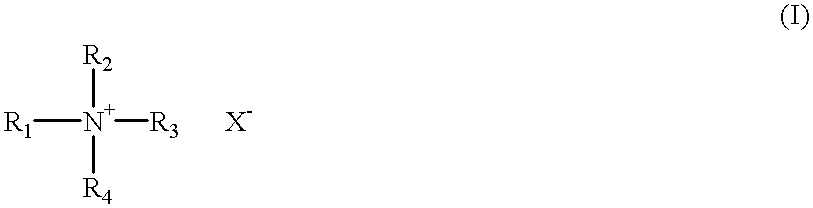

In [17]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
results_df['predicted_A']

0    ```json\n[\n  {"a": "C",l",\n  "b": 1,\n  "a1": 0, "a2": 1,\n "a2": 1, "a3": 1, "a4": 1, "a5": 1, "a6": 1, "a7": 1, "a8": 1, "a9": 1, "aa": 1, "ab": 1, "ac": 1, "ad": 1, "ae": 1, "af": 1, "ag": 1, "ah": 1, "ai": 1, "aj": 1, "ak": 1, "am": 1, "an": 1, "anj": 1, "anm": 1, "anm": 1, "anm": 1, "anm": 1, "anm": 1, "anm": 1, "anm": 1, "anm": 1, "anm": 1, "anm": 1, "anm": 1, "anm": 1, "anm": 1, "anm": 1, "anm": 1, "anm": 1, "anm": 1, "anm": 1, "anm": 1, "anm": 1, "anm": 1, "anm": 1, "anm": 1, "anm": 1, "anm": 1, "anm": 1, "anm": 1, "anm": 1, "anm": 1, "anm": 1, "anm": 1, "anm": 1, "anm": 1, "anm": 1, "anm": 1, "anm": 1, "anm": 1, "anm": 1, "anm": 1, "anm": 1, "anm": 1, "anm": 1, "anm": 1, "anm": 1, "anm": 1, "anm": 1, "anm": 1, "anm": 1,
Name: predicted_A, dtype: object

In [29]:
results_df.to_pickle('/workspace/temp/sample_results_cotq.pkl')

In [ ]:
# 추론 다 끝났을 경우
import glob

chunk_list = glob.glob("/workspace/temp/*.pkl")
chunk_df = pd.DataFrame()
for i in chunk_list:
    chunk_df = pd.concat([chunk_df, pd.DataFrame(pd.read_pickle(i))])